In [14]:
import yaml
from pathlib import Path
from utils import Tau3MuDataset, Root2Df
import matplotlib.pyplot as plt

In [3]:
setting = 'GNN-full-dR-1-mix-debug'
config = yaml.safe_load(Path(f'./configs/{setting}.yml').open('r'))

In [4]:
data_config = config['data']
data_dir = Path(data_config['data_dir'])
dfs = Root2Df(data_dir / 'raw').read_df(setting)

[INFO] Reading skim configuration file: ../data/raw/processing.cfg
[INFO] ../data/raw/MinBiasPU200_MTD.root loaded!
[INFO] ../data/raw/DsTau3muPU0_MTD.root loaded!
[INFO] ../data/raw/DsTau3muPU200_MTD.root loaded!


In [50]:
neg200 = dfs['MinBiasPU200_MTD']
pos200 = dfs['DsTau3muPU200_MTD']
pos0 = dfs.get('DsTau3muPU0_MTD', None)

In [51]:
pos0 = pos0[pos0.n_gen_tau == 1].reset_index(drop=True)

In [52]:
a = pos0.apply(lambda x: (x['mu_hit_station'] == 1).sum(), axis=1)

(array([0.21484673, 0.1859782 , 0.19772273, 0.13166898, 0.10132424,
        0.06155566, 0.04473124, 0.02632424, 0.01818557, 0.01766238]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

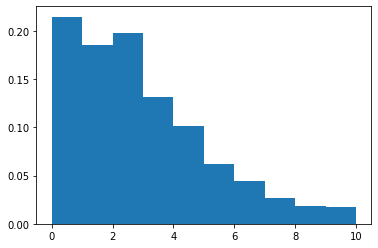

In [54]:
plt.hist(a, density=True, bins=10, range=(0, 10))

In [59]:
b = pos0['n_mu_hit']

(array([0.25224085, 0.19362067, 0.1689139 , 0.08846452, 0.06388345,
        0.04241498, 0.03959752, 0.0365751 , 0.03908103, 0.07520796]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

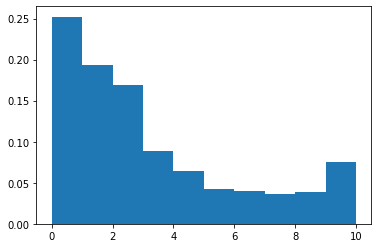

In [60]:
plt.hist(b, density=True, bins=10, range=(0, 10))

In [36]:
b = neg200.apply(lambda x: (x['mu_hit_station'] == 2).sum(), axis=1)

In [40]:
b = b[b < 10]

(array([0.38941522, 0.11632092, 0.17115473, 0.10762977, 0.10671087,
        0.05899328, 0.0713577 , 0.03672802, 0.0331827 , 0.0196179 ]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

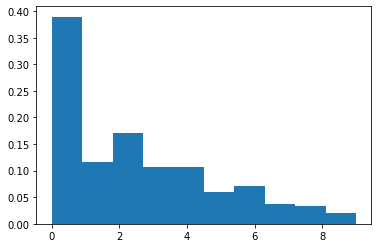

In [42]:
plt.hist(b, density=True)

In [29]:
def filter_mu_by_pt_eta(x):
    return ((x['gen_mu_pt'] > 0.5).sum() == 3) and ((abs(x['gen_mu_eta']) < 2.8).sum() == 3) and ((abs(x['gen_mu_eta']) > 1.2).sum() == 3)

idx = pos0.apply(lambda x: filter_mu_by_pt_eta(x), axis=1)

In [30]:
nosoft_pos0 = pos0[idx == True]

In [31]:
len(nosoft_pos0)

87692

In [32]:
c = nosoft_pos0.apply(lambda x: (x['mu_hit_station'] <= 2).sum(), axis=1)

(array([0.08143794, 0.11775387, 0.13927779, 0.12594133, 0.12492245,
        0.11746276, 0.11968247, 0.10305283, 0.09683036, 0.08474931]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

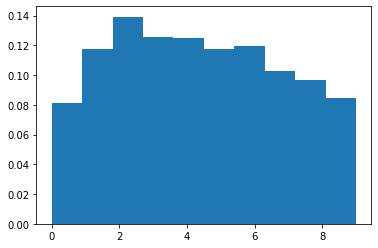

In [33]:
c = c[c < 10]
plt.hist(c, density=True)

In [73]:
def filter_mu_by_pt_eta(x):
    # return ((x['gen_mu_pt'] > 0.9).sum() == 3)
    return ((x['mu_hit_station'] <= 4).sum() >= 0)


idx = pos0.apply(lambda x: filter_mu_by_pt_eta(x), axis=1)

In [74]:
nosoft_pos0 = pos0[idx == True]
len(nosoft_pos0)

466320

(array([0.29109254, 0.22344332, 0.19493105, 0.10209037, 0.07372318,
        0.048948  , 0.04569657, 0.04220862, 0.04510053, 0.04387691]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

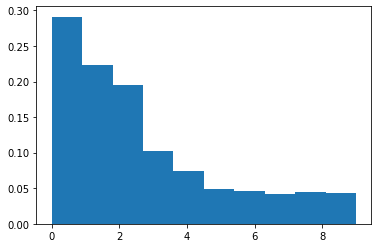

In [75]:
c = nosoft_pos0.apply(lambda x: (x['mu_hit_station'] <= 4).sum(), axis=1)
c = c[c < 10]
plt.hist(c, density=True)

In [41]:
len(neg200)

499600

In [43]:
100000 / (499600-100000)

0.2502502502502503